# TP1: Classifieur linéaire, fonction de perte **Entropie croisée**

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)
    X_batch -= np.mean(X_batch, axis = 0)

    # Ajout du biais
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    X_batch = np.hstack([X_batch, np.ones((X_batch.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)


## Question 1

Les prochaines étapes consistent à implanter le calcul de **l'entropie croisée** et de son **gradient**.   Vous commencerez avec une version naïve impliquant une boucle *for* sur l'ensemble des éléments d'une batch pour ensuite implanter une version vectorisée.   Mais avant de commencer à coder, veuillez donner ici la formule de l'entropie croisée et du gradient pour une mini-batch de 500 données contenue dans le tableau

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = -ln(S) + lamb*norm(W,2) avec S = exp(X.W) / sum(exp(X.W), 1)$$

$$dW = [(S - t)*X].T + 2*lamb*W$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et vectorielles

## Classifieur linéaire SOFTMAX

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `softmax_ce_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  


Commençons par tester la **forward pass + l'entropie croisée**.  Pour l'instant, ignorons la rétro-propagation.

In [12]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.276854
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

[[-0.55585138  5.77349909 -0.61236922 ... -0.67253637 -0.87537157
  -0.6617125 ]
 [ 0.17387348 -1.80598346  0.19155258 ...  0.21037321  0.27382122
   0.20698745]
 [-0.28636859  2.97444401 -0.31548597 ... -0.34648343 -0.45098192
  -0.34090709]
 ...
 [-0.61429695  6.38055963 -0.67675741 ... -0.7432509  -0.96741342
  -0.73128895]
 [ 0.04694006 -0.48755546  0.05171283 ...  0.05679377  0.07392262
   0.05587973]
 [ 0.30834142 -3.20267064  0.33969294 ...  0.37306882  0.48558539
   0.36706461]]
Bravo!
loss error: 0.000000


In [13]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 2.356459
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


[[-1.63553662 -0.45649559 -1.05686044 ...  0.86572232 -2.16513188
  -2.27858858]
 [-2.1048624   0.28366624 -1.39517522 ...  0.52994945 -3.74530299
  -3.17648768]
 [-2.93143808 -0.49561605  0.06348929 ...  0.40347084 -5.83713235
  -4.95945962]
 ...
 [ 0.28318078  2.29331036  0.42042742 ... -0.80513258 -0.17775923
  -2.32193285]
 [ 0.17581504  2.03569961  0.67592454 ...  1.3667073  -1.99752957
  -2.84210116]
 [ 0.02817192 -0.0407199  -0.01173696 ... -0.00808671  0.02431986
  -0.00981905]]
Bravo!
loss error: 0.000000


## Question 2:
Pourquoi s'attend-on que la loss soit approximativement -np.log(1/nb_classes))?

**Votre réponse:** Lorsque l'on initialise aléatoirement les poids, nous savons que l'entropie sera maximale. Pour cela, la prédiction (correspondant ici à une probabilité) associée à chaque classe sera de 1/nb_classes. Vu différemment, nous pouvons voir que, si le modèle n'est pas entraîné, il va prédire de façon égale chaque classe.


In [14]:
###################################################################################
#  Vérification simple: s'assurer que l'entropie-croisée soit proche de           #
#  -log(1/nb_classes)                                                             #
###################################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss d'un modèle non-entrainé devrait s'approcher de -log(0.1).
print('Softmax loss: %f' % loss)
print('Sanity check: %f' % (-np.log(0.1)))

[[-2.43098977e+00 -1.20913328e+00 -6.81027658e-01 ...  6.86160793e-01
  -1.24796336e-01 -3.19055346e+00]
 [-2.81695360e+00 -5.80283642e-01 -1.11202598e+00 ...  4.46219742e-01
  -1.48431681e+00 -4.08483887e+00]
 [-3.79122796e+00 -1.28590230e+00  3.25074256e-01 ...  5.54251616e-01
  -3.36434630e+00 -6.11138620e+00]
 ...
 [-4.60994269e-01  1.33338845e+00  8.34242035e-01 ... -1.34774259e+00
   1.31663061e+00 -9.06365651e-01]
 [-6.58748327e-01  1.08145126e+00  9.29722438e-01 ...  1.07841747e+00
  -3.09743356e-01 -1.59750900e+00]
 [ 3.00797539e-02 -4.02401683e-02 -1.10506968e-02 ... -6.03864912e-03
   2.59833688e-02 -1.36873808e-02]]
Softmax loss: 2.339132
Sanity check: 2.302585


## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [15]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.30114875
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-0.1279744 ,  1.15786877, -0.12847105])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

[[-0.1279744   1.15786877 -0.12847105 ... -0.12895357 -0.13032041
  -0.12886991]
 [ 0.04003112 -0.36218796  0.04018648 ...  0.04033741  0.04076497
   0.04031124]
 [-0.06593102  0.59652141 -0.06618689 ... -0.06643548 -0.06713966
  -0.06639238]
 ...
 [-0.1414304   1.27961408 -0.14197927 ... -0.14251253 -0.14402308
  -0.14242007]
 [ 0.01080707 -0.0977787   0.01084901 ...  0.01088976  0.01100519
   0.01088269]
 [ 0.07098985 -0.64229201  0.07126535 ...  0.07153302  0.07229123
   0.07148661]]
Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [16]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)
print(dW[0,0:4])
# La loss suivante est celle que vous devriez obtenir
target_loss = 2.35680883
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-1.68817739, -1.37204569, -0.46158773, 1.9206649])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

[[-1.68817739e+00 -1.37204569e+00 -4.61587730e-01 ...  8.34288820e-01
  -9.34764094e-01 -4.93670879e+00]
 [-2.06141741e+00 -9.99790842e-01 -7.64298623e-01 ...  5.35426798e-01
  -2.35436909e+00 -6.23144698e+00]
 [-2.86517804e+00 -1.82217642e+00  7.03969046e-01 ...  4.17467420e-01
  -4.13619756e+00 -8.48146735e+00]
 ...
 [ 2.33613191e-01  1.53139723e+00  2.61028583e-01 ... -1.30382203e+00
   5.89147437e-01 -2.84850674e+00]
 [ 1.22175450e-01  1.20625036e+00  4.12379388e-01 ...  7.80103824e-01
  -9.49227030e-01 -3.60700249e+00]
 [ 2.80292466e-02 -4.27386483e-02 -1.21210217e-02 ... -7.08090406e-03
   2.31554188e-02 -1.50200384e-02]]
[-1.68817739 -1.37204569 -0.46158773  1.9206649 ]
Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de l'entropie croisée (et de son gradient) via la fonction *softmax_ce_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le teste du **gradient numérique**

In [17]:
##############################################################################
# Vérifions que le fait d'augmenter le terme de régularisation L2            #
# augmente la loss...                                                        #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.2
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


[[-2.28130506e+00  1.27850939e+00  1.66059732e+00 ... -2.37019660e+00
   5.14711721e-01 -3.97687527e+00]
 [-2.87029679e+00  1.66976915e+00  1.72528070e+00 ... -2.43685582e+00
  -1.12453126e+00 -4.43379397e+00]
 [-5.15362069e+00  1.85533637e+00  3.00834886e+00 ... -2.40515039e+00
  -2.78472419e+00 -5.35961770e+00]
 ...
 [-3.19806748e-01  9.41441138e-02 -3.14332935e-01 ... -6.04732343e-01
   2.71569149e+00 -3.01589257e+00]
 [-1.55361825e+00 -6.93614011e-01  9.17299004e-01 ...  1.11015254e+00
   3.57676871e-01 -3.54042096e+00]
 [-8.52464676e-03  1.59904102e-02 -9.81805597e-03 ...  5.80975993e-03
  -4.04981619e-03 -1.65769038e-02]]
[[-2.24881816e+00  1.26627427e+00  1.65003389e+00 ... -2.38542074e+00
   5.21092503e-01 -3.98186268e+00]
 [-2.84105463e+00  1.62856633e+00  1.71883235e+00 ... -2.45441299e+00
  -1.12368699e+00 -4.42213767e+00]
 [-5.17563307e+00  1.87823084e+00  3.02638068e+00 ... -2.42386578e+00
  -2.79008196e+00 -5.34901059e+00]
 ...
 [-3.11725843e-01  1.11904666e-01 -3.4284908

In [18]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

[[-2.28130506e+00  1.27850939e+00  1.66059732e+00 ... -2.37019660e+00
   5.14711721e-01 -3.97687527e+00]
 [-2.87029679e+00  1.66976915e+00  1.72528070e+00 ... -2.43685582e+00
  -1.12453126e+00 -4.43379397e+00]
 [-5.15362069e+00  1.85533637e+00  3.00834886e+00 ... -2.40515039e+00
  -2.78472419e+00 -5.35961770e+00]
 ...
 [-3.19806748e-01  9.41441138e-02 -3.14332935e-01 ... -6.04732343e-01
   2.71569149e+00 -3.01589257e+00]
 [-1.55361825e+00 -6.93614011e-01  9.17299004e-01 ...  1.11015254e+00
   3.57676871e-01 -3.54042096e+00]
 [-8.52464676e-03  1.59904102e-02 -9.81805597e-03 ...  5.80975993e-03
  -4.04981619e-03 -1.65769038e-02]]
[[-2.28130389e+00  1.27851060e+00  1.66058731e+00 ... -2.37019415e+00
   5.14712841e-01 -3.97687336e+00]
 [-2.87029678e+00  1.66976887e+00  1.72528523e+00 ... -2.43685478e+00
  -1.12453156e+00 -4.43379372e+00]
 [-5.15362100e+00  1.85533509e+00  3.00836141e+00 ... -2.40515052e+00
  -2.78472523e+00 -5.35961822e+00

[[-2.28131930e+00  1.27849490e+00  1.66058302e+00 ... -2.37006706e+00
   5.14698570e-01 -3.97688926e+00]
 [-2.87031492e+00  1.66975055e+00  1.72526181e+00 ... -2.43668641e+00
  -1.12454885e+00 -4.43381294e+00]
 [-5.15364679e+00  1.85530981e+00  3.00832153e+00 ... -2.40490648e+00
  -2.78474991e+00 -5.35964535e+00]
 ...
 [-3.19809511e-01  9.41415808e-02 -3.14335647e-01 ... -6.04702096e-01
   2.71568877e+00 -3.01589592e+00]
 [-1.55362562e+00 -6.93620581e-01  9.17292010e-01 ...  1.11022360e+00
   3.57670030e-01 -3.54042916e+00]
 [-8.52459919e-03  1.59904593e-02 -9.81804825e-03 ...  5.80964138e-03
  -4.04985768e-03 -1.65768248e-02]]
[[-2.28129083e+00  1.27852389e+00  1.66061162e+00 ... -2.37032614e+00
   5.14724872e-01 -3.97686129e+00]
 [-2.87027866e+00  1.66978774e+00  1.72529958e+00 ... -2.43702523e+00
  -1.12451368e+00 -4.43377500e+00]
 [-5.15359459e+00  1.85536293e+00  3.00837619e+00 ... -2.40539430e+00
  -2.78469848e+00 -5.35959005e+00]
 ...
 [-3.19803985e-01  9.41466470e-02 -3.1433022

[[-2.24879889e+00  1.26629287e+00  1.65005448e+00 ... -2.38540205e+00
   5.21115238e-01 -3.98184550e+00]
 [-2.84103753e+00  1.62858266e+00  1.71885087e+00 ... -2.45439640e+00
  -1.12366693e+00 -4.42212287e+00]
 [-5.17561690e+00  1.87824619e+00  3.02639803e+00 ... -2.42385025e+00
  -2.79006291e+00 -5.34899716e+00]
 ...
 [-3.11716553e-01  1.11912881e-01 -3.42839713e-01 ... -5.89111531e-01
   2.73779702e+00 -3.00530642e+00]
 [-1.55742082e+00 -6.99700416e-01  8.93643036e-01 ...  1.07981789e+00
   3.52043986e-01 -3.53284424e+00]
 [ 2.38604550e-03  4.43686197e-02 -2.49534500e-02 ... -5.55389069e-03
   8.92878593e-03 -2.40050043e-02]]
numerical: 1.168015, analytic 1.155938, relative error: 5.196695e-03
[[-2.24882927e+00  1.26626268e+00  1.65002273e+00 ... -2.38531697e+00
   5.21081585e-01 -3.98187351e+00]
 [-2.84106810e+00  1.62855240e+00  1.71881878e+00 ... -2.45428807e+00
  -1.12370004e+00 -4.42215132e+00]
 [-5.17564861e+00  1.87821485e+00  3.02636467e+00 ... -2.42372096e+00
  -2.79009724e+

[[-2.24878664e+00  1.26630828e+00  1.65006899e+00 ... -2.38573007e+00
   5.21126211e-01 -3.98182774e+00]
 [-2.84102684e+00  1.62859653e+00  1.71886403e+00 ... -2.45468640e+00
  -1.12365745e+00 -4.42210748e+00]
 [-5.17560601e+00  1.87825964e+00  3.02641084e+00 ... -2.42412798e+00
  -2.79005345e+00 -5.34898234e+00]
 ...
 [-3.11719683e-01  1.11912205e-01 -3.42841070e-01 ... -5.89189276e-01
   2.73779385e+00 -3.00530605e+00]
 [-1.55742320e+00 -6.99700803e-01  8.93641737e-01 ...  1.07973670e+00
   3.52041430e-01 -3.53284305e+00]
 [ 2.38593446e-03  4.43685158e-02 -2.49535925e-02 ... -5.55385849e-03
   8.92869117e-03 -2.40051238e-02]]
numerical: -0.726355, analytic -0.722099, relative error: 2.938460e-03


## Softmax et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **softmax_ce_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

In [11]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction softmax_ce_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
start = time.time()
loss_naive, grad_naive = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import softmax_ce_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = softmax_ce_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

[[-2.28130506e+00  1.27850939e+00  1.66059732e+00 ... -2.37019661e+00
   5.14711722e-01 -3.97687527e+00]
 [-2.87029679e+00  1.66976914e+00  1.72528070e+00 ... -2.43685582e+00
  -1.12453126e+00 -4.43379397e+00]
 [-5.15362069e+00  1.85533637e+00  3.00834886e+00 ... -2.40515039e+00
  -2.78472420e+00 -5.35961770e+00]
 ...
 [-3.19806748e-01  9.41441155e-02 -3.14332938e-01 ... -6.04732342e-01
   2.71569149e+00 -3.01589256e+00]
 [-1.55361825e+00 -6.93614012e-01  9.17299002e-01 ...  1.11015254e+00
   3.57676871e-01 -3.54042096e+00]
 [-8.52464567e-03  1.59904130e-02 -9.81805749e-03 ...  5.80975879e-03
  -4.04981490e-03 -1.65769045e-02]]
naive loss: 2.387263e+00 computed in 0.147961s
vectorized loss: 2.387263e+00 computed in 0.007005s
bravo pour la loss!
Loss difference: 0.000000
il y a un bug au niveau du gradient
Gradient difference: 0.000000


In [26]:
grad_difference

1.7480689642731704e-07

## Entraînement
À l'aide de la classe **LinearClassifier** ainsi que de la fonction vectorisée **softmax_ce_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

train vs val acc 0.280490 / 0.296000


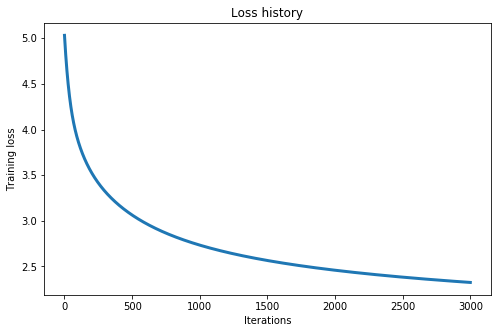

In [12]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 1

classifier = LinearClassifier(softmax_ce_forward_backward)
#
# TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
#
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000, verbose = False)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

5
5
best validation accuracy achieved during cross-validation: 0.999000


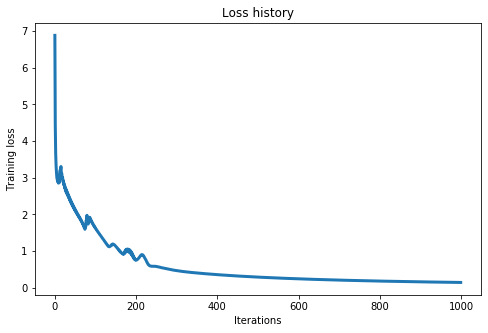

In [15]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(1e-7, 1e-5, 5)
regularization_strengths = np.linspace(1e3, 1e7, 5)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 1000    #
#  vous devriez obtenir une précision de classification supérieur à 0.38 sur #
#  l'ensemble de validation, et de 0.37 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################

print(len(learning_rates))
print(len(regularization_strengths))

best_lr = 0.0
best_reg = 0.0

for lr in learning_rates:
    for reg in regularization_strengths:
        
        classifier = LinearClassifier(softmax_ce_forward_backward)
        validation_loss_history = classifier.train(X_val, y_val, learning_rate=lr, reg=reg, num_iter=1000)
        y_val_pred = classifier.predict(X_val)
        pred = np.mean(y_val == y_val_pred)
        
        if(pred > best_val):
            best_lr = lr
            best_reg = reg
            best_val = pred
            best_classifier = classifier
            best_loss_history = validation_loss_history
        

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [16]:
# On évalue le modèle sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Test set accuracy: %f' % (test_accuracy) )

Test set accuracy: 0.269000


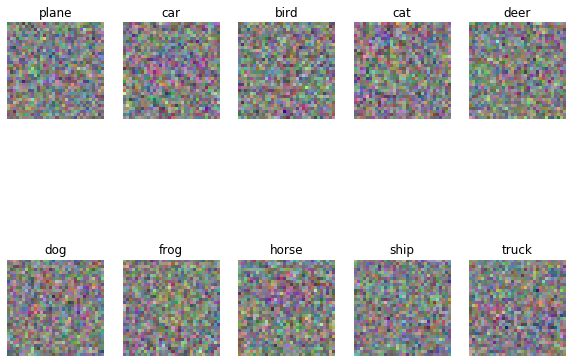

In [17]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])